In [1]:
# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install mne-connectivity

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import gc
from glob import glob
import numpy as np
import scipy as sp
import statistics, math
import random as rd
import pandas as pd
import dataframe_image as dfi
pd.options.display.float_format = '{:,.2f}'.format

from math import sqrt, ceil

from sklearn import metrics
from sklearn import decomposition, cluster
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from scipy.spatial.distance import correlation
from IPython.display import display

In [4]:
import heartpy as hp
import neurokit2 as nk 

In [5]:
import mne
#import mne_connectivity

from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap, annotate_muscle_zscore, peak_finder,
                               find_eog_events, find_ecg_events, ica_find_ecg_events, find_bad_channels_maxwell)
from mne.time_frequency import (tfr_array_multitaper, psd_array_multitaper, csd_array_multitaper, csd_array_morlet)

from mne_connectivity import seed_target_indices, spectral_connectivity_epochs, spectral_connectivity_time

print(mne.__file__)
print(mne.__version__)

C:\Users\Lenovo\anaconda3\lib\site-packages\mne\__init__.py
1.3.1


In [6]:
import plotly.graph_objects as go
from gtda.time_series import SingleTakensEmbedding, TakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve, Scaler, Filtering, Amplitude, PersistenceEntropy, NumberOfPoints
from gtda.plotting import plot_point_cloud


In [7]:
# Configure the graphics engine

import matplotlib.pyplot as plt
plt.rc('figure', max_open_warning=200)
%matplotlib notebook
#%matplotlib inline
#%matplotlib qt

In [8]:
import seaborn as sns
# Apply the default theme
sns.set_theme()

In [9]:
# My modules
#import my_varexplore as ve
#import my_dimreduct as dr
#import my_clustquality as cq
#import my_stageprocess as spr

# Global variables

In [12]:
gc.collect()

38

In [13]:
#==============================================
# Input main data information
#==============================================

# Number of the subject for analysis
SUBJ_NUM = 23

# Type of the test (math / video)
TEST_TYPE = 'math' 
#TEST_TYPE = 'video'


In [14]:
# Initalize path variables for main folders

print(os.getcwd())

if (SUBJ_NUM < 10):
    subj_dir_name = '0'+str(SUBJ_NUM)+'_'+TEST_TYPE
else:
    subj_dir_name = str(SUBJ_NUM)+'_'+TEST_TYPE
    
root_dir_path = os.path.join(os.getcwd(), 'work_data', subj_dir_name)
init_dir_path = os.path.join(root_dir_path, 'initial_data')
raw_dir_path = os.path.join(root_dir_path, 'stages_raw')
ep_dir_path = os.path.join(root_dir_path, 'stages_epochs')
ft_dir_path = os.path.join(root_dir_path, 'features')

print(init_dir_path)
print(raw_dir_path)
print(ep_dir_path)
print(ft_dir_path)


C:\Users\Lenovo\PycharmProjects\Huawei
C:\Users\Lenovo\PycharmProjects\Huawei\work_data\23_math\initial_data
C:\Users\Lenovo\PycharmProjects\Huawei\work_data\23_math\stages_raw
C:\Users\Lenovo\PycharmProjects\Huawei\work_data\23_math\stages_epochs
C:\Users\Lenovo\PycharmProjects\Huawei\work_data\23_math\features


In [15]:
# Create main folders if not exist

if not os.path.exists(root_dir_path):
    os.mkdir(root_dir_path)
if not os.path.exists(init_dir_path):
    os.mkdir(init_dir_path)
if not os.path.exists(raw_dir_path):
    os.mkdir(raw_dir_path)
if not os.path.exists(ep_dir_path):
    os.mkdir(ep_dir_path)
if not os.path.exists(ft_dir_path):
    os.mkdir(ft_dir_path)


In [16]:
# Frequency bands

bands = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 8, 'Theta (4-8 Hz)', 'T'), (8, 14, 'Alpha (8-14 Hz)', 'A'), 
         (14, 25, 'Beta (14-25 Hz)', 'B'), (25, 40, 'Gamma (25-40 Hz)', 'G')]

str_freq = [bands[i][3] for i in range(len(bands))]

In [17]:
# Localization by scalp regions

regions = [(['Fp1','Fp2'], 'Fp', 'Pre-frontal'), (['F7','F3','FC5'], 'LF', 'Left Frontal'), 
           (['Fz','FC1','FC2'], 'MF', 'Midline Frontal'), (['F4','F8','FC6'], 'RF', 'Right Frontal'),
           (['T7','CP5','P7'], 'LT', 'Left Temporal'), (['T8','CP6','P8'], 'RT', 'Right Temporal'), 
           (['C3','Cz','C4'], 'Cen', 'Central'), (['P3','Pz','P4','CP1','CP2'], 'Par', 'Parietal'), 
           (['O1','Oz','O2'], 'Occ', 'Occipital')]

SLICE_LEN = 10 #number of epochs to measure physiological features, coherence and PLV

n_freq = len(str_freq)
n_regions = len(regions)


# Loading data

C:\Users\Lenovo\PycharmProjects\Huawei\work_data\23_math\initial_data\23_math-edf.edf
Extracting EDF parameters from C:\Users\Lenovo\PycharmProjects\Huawei\work_data\23_math\initial_data\23_math-edf.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2620499  =      0.000 ...  5240.998 secs...
['Fp1', 'Fz', 'F3', 'F7', 'HEOG', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'VEOG', 'FC6', 'FC2', 'F4', 'F8', 'FP2', 'Photosensor', 'skinconductance', 'heartrate', 'respiratory', 'Sync', 'zygomaticus', 'corrugator']
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, HEOG, FC5, FC1, C3, T7, CP5, CP1, Pz, P3, P7, ...
 chs: 37 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2023-03-17 14:16:50 UTC
 nchan: 37
 projs: []
 sfreq: 500.0 Hz
>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    6.5s finished


Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


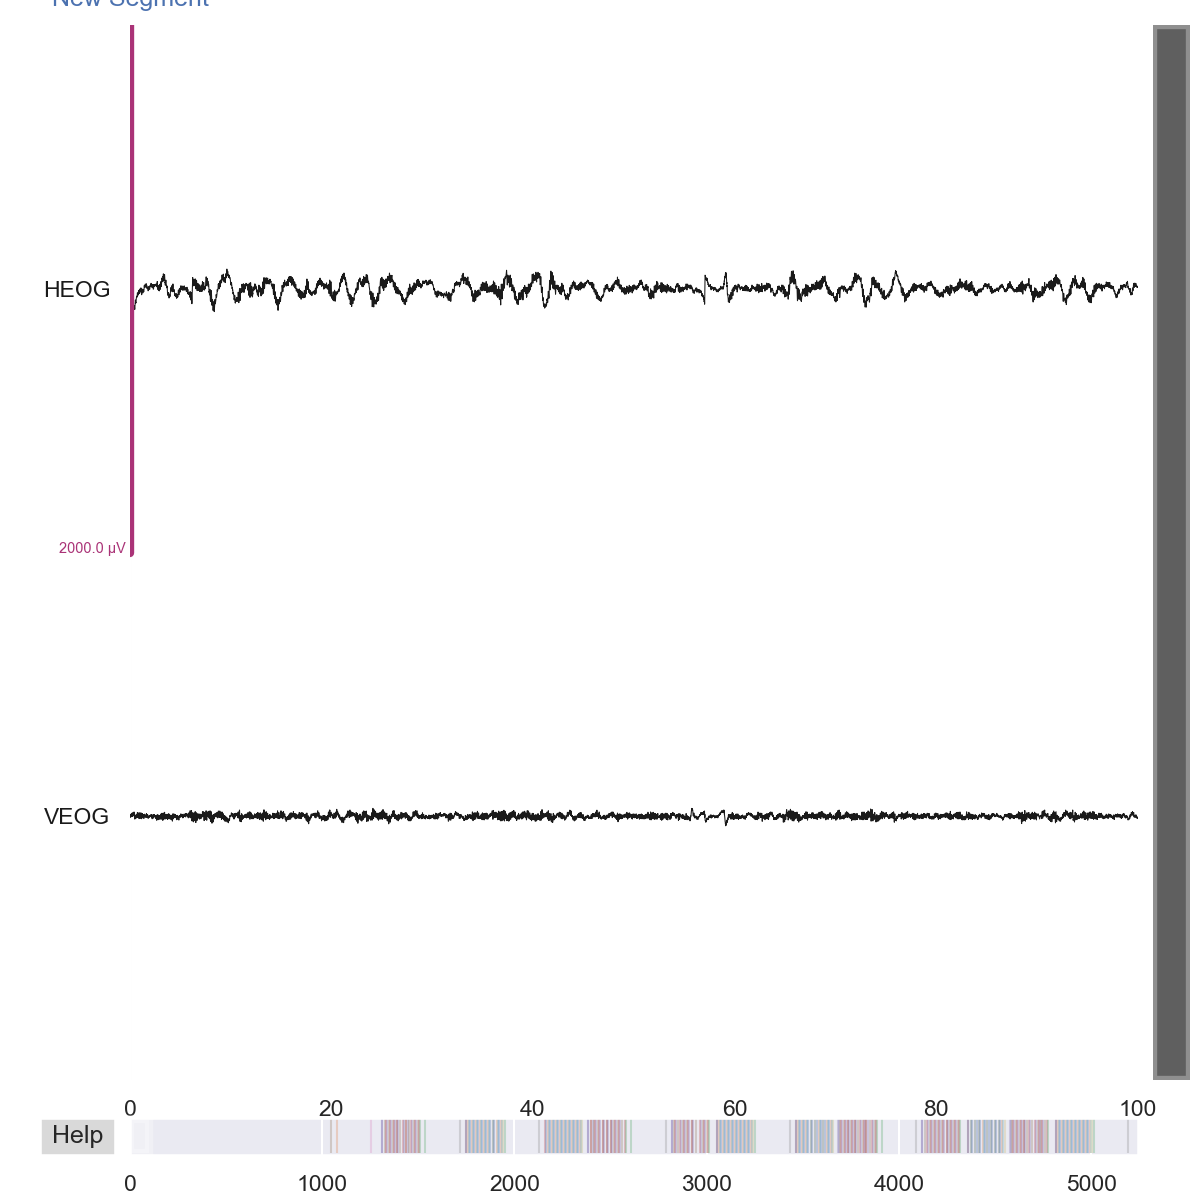

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    6.7s finished


<IPython.core.display.Javascript object>


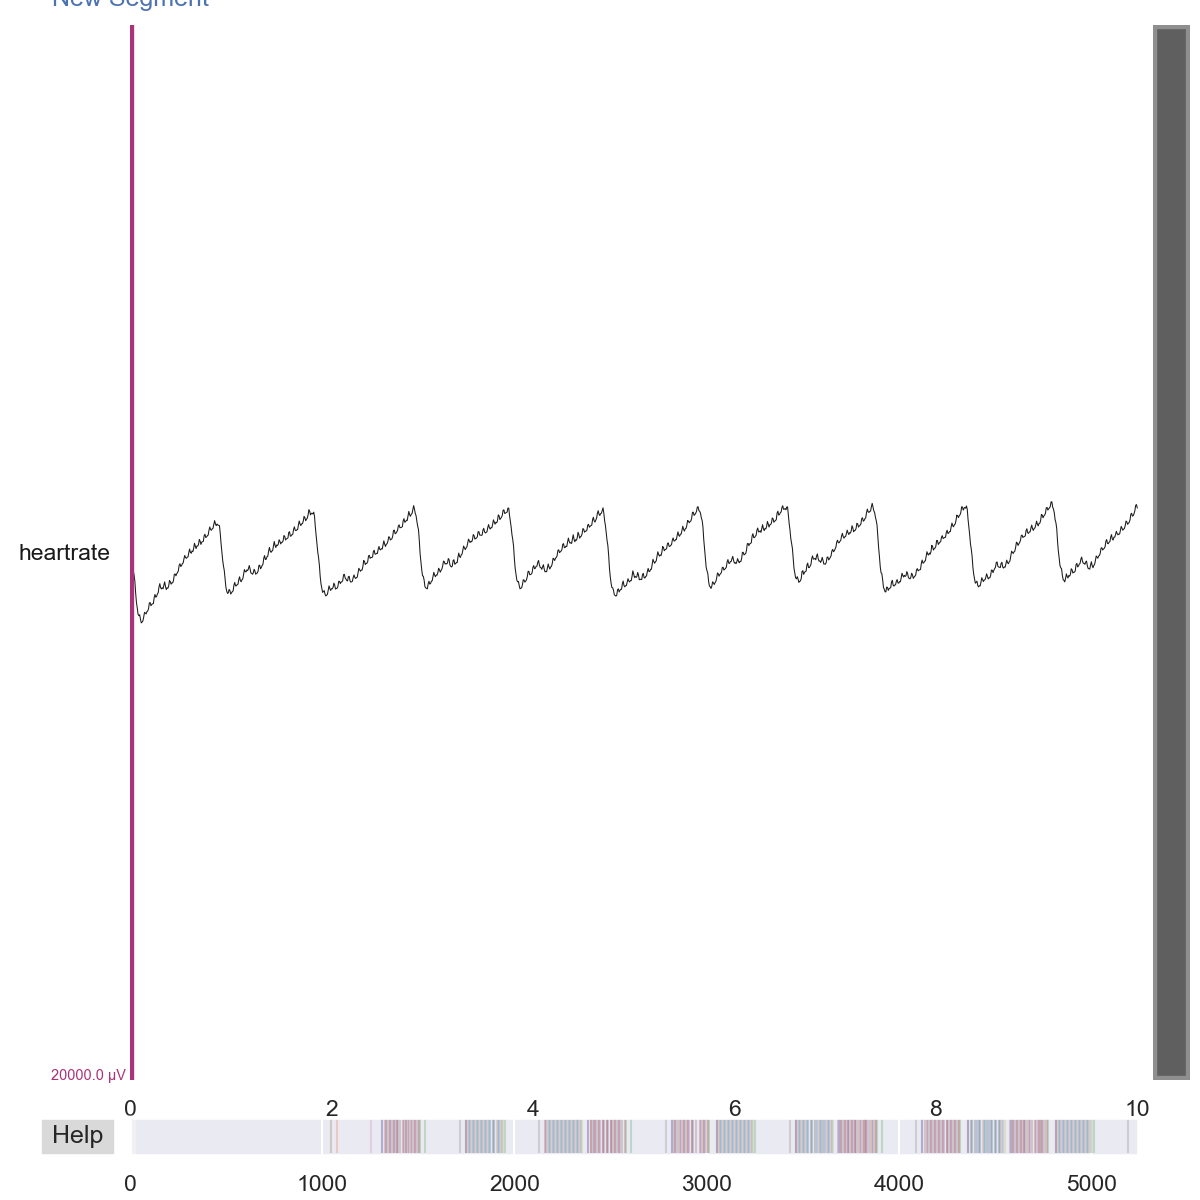

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 165001 samples (330.002 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   40.4s finished


<IPython.core.display.Javascript object>


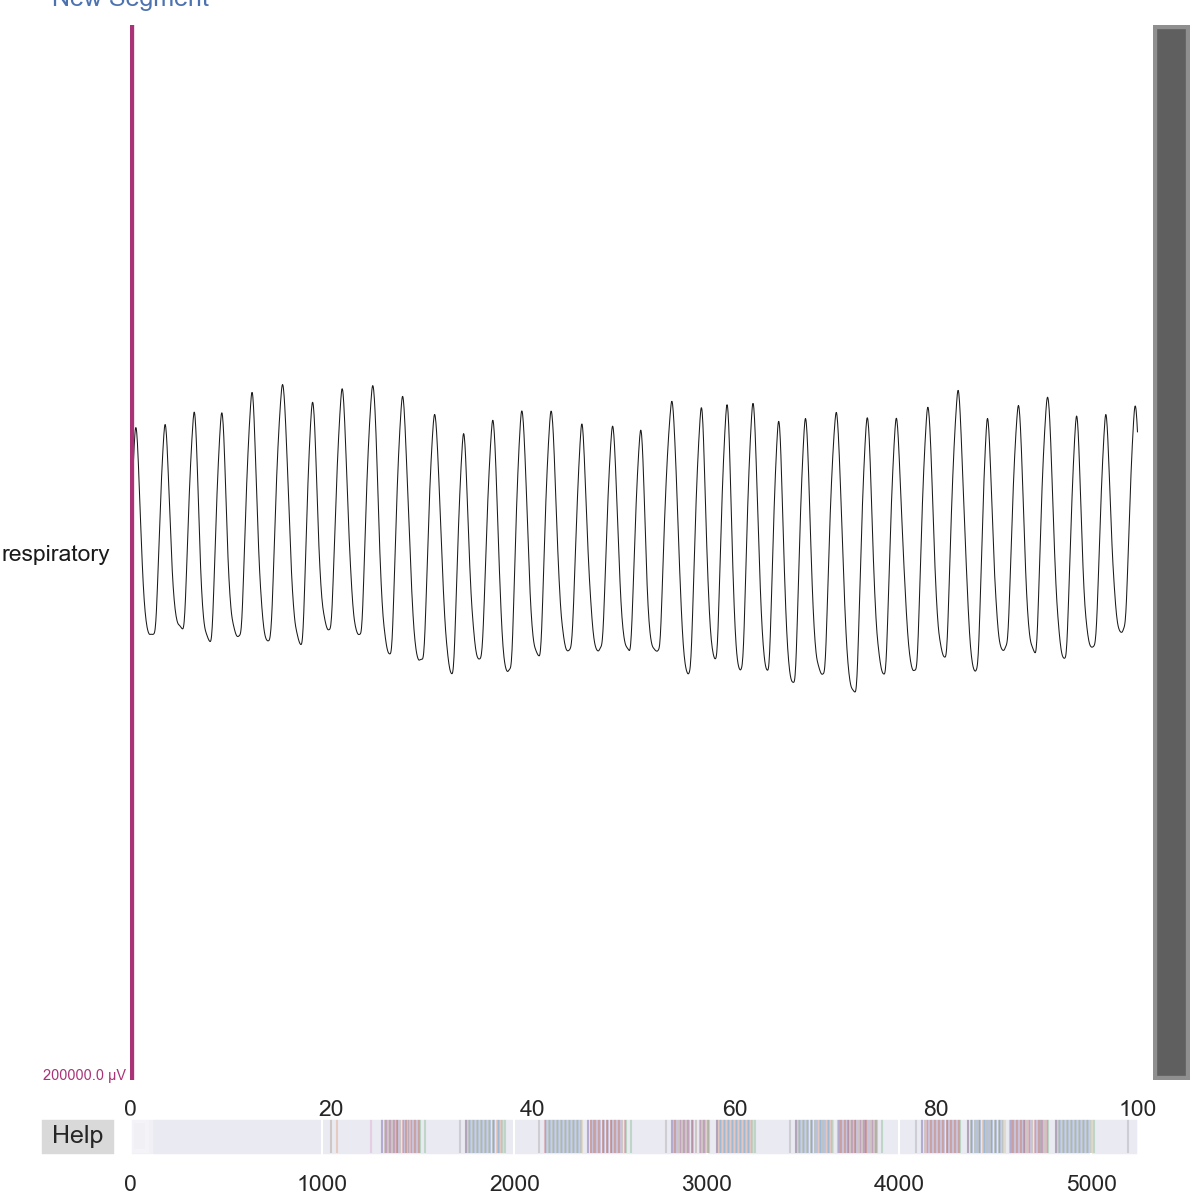

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 16501 samples (33.002 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


<IPython.core.display.Javascript object>


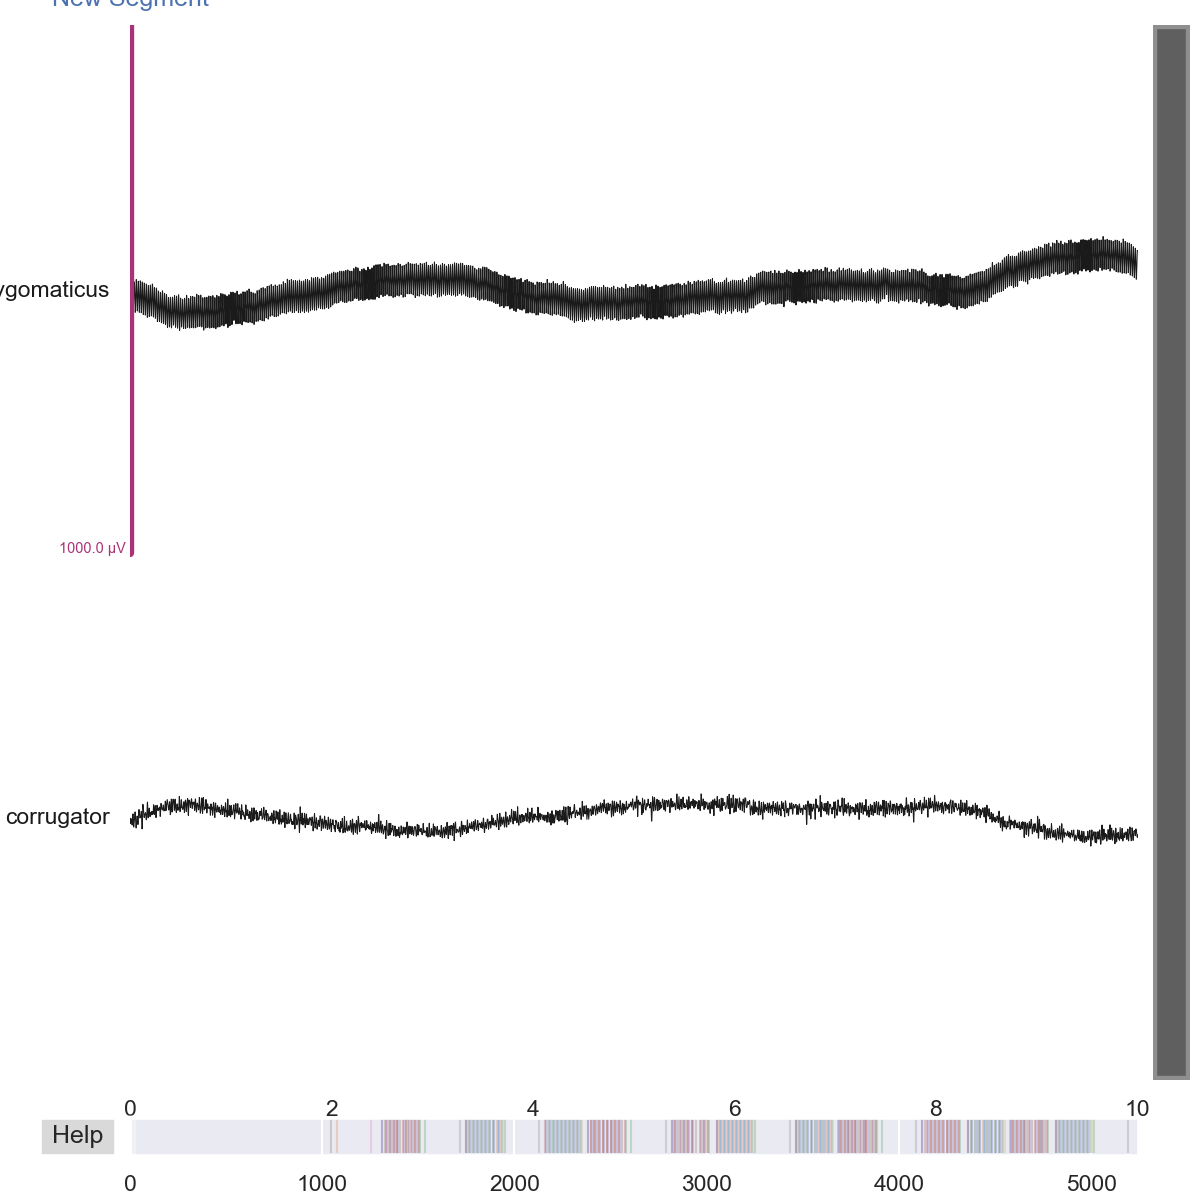

['Fp1', 'Fz', 'F3', 'F7', 'HEOG', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'VEOG', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'Photosensor', 'skinconductance', 'heartrate', 'respiratory', 'Sync', 'zygomaticus', 'corrugator']



<RawEDF | 23_math-edf.edf, 37 x 2620500 (5241.0 s), ~739.8 MB, data loaded>

In [18]:
# Load and analise original EEG and biological data

EOG_ch = ['HEOG', 'VEOG']
ECG_ch = ['heartrate']
resp_ch = ['respiratory']
marker_ch = ['marker']
zygomat_ch = ['zygomaticus', 'corrugator']
skincond_ch = ['skinconductance']
corrug_ch = ['corrugator']

# Compose initial data edf-filename
edf_fname = str(SUBJ_NUM)+'_'+TEST_TYPE+'-edf.edf'
#edf_fname = str(SUBJ_NUM)+'_'+TEST_TYPE+'.vhdr'
edf_file_path = os.path.join(init_dir_path, edf_fname)
print(edf_file_path)

# Load data
data_raw = mne.io.read_raw_edf(os.path.join(init_dir_path, edf_fname), preload=True)
#data_raw = mne.io.read_raw(os.path.join(init_dir_path, edf_fname), preload=True)
samp_rate = data_raw.info['sfreq']

print(data_raw.info.ch_names)
print(data_raw.info)

# Plot additional non-eeg channels
data_eog = data_raw.copy().filter(l_freq=1, h_freq=40).pick_channels(EOG_ch)
data_eog.plot(scalings = dict(eeg=1e-3), duration=100)
data_ecg = data_raw.copy().filter(l_freq=0.5, h_freq=40).pick_channels(ECG_ch)
data_ecg.plot(scalings = dict(eeg=1e-2), duration=10)
data_resp = data_raw.copy().filter(l_freq=0.01, h_freq=10).pick_channels(resp_ch)
data_resp.plot(scalings = dict(eeg=1e-1), duration=100)

#data_marker = data_raw.copy().pick_channels(marker_ch)
#data_marker.plot(scalings = dict(eeg=1e-2), duration=1000)
data_zygomat = data_raw.copy().pick_channels(zygomat_ch).filter(l_freq=0.1, h_freq=100)
data_zygomat.plot(scalings = dict(eeg=5e-4), duration=10)
#data_skincond = data_raw.copy().pick_channels(skincond_ch)
#data_skincond.plot(scalings = dict(eeg=1e-4), duration=100)
#data_corrug = data_raw.copy().pick_channels(corrug_ch)
#data_corrug.plot(scalings = dict(eeg=1e-3), duration=100)

# Set channel types
change_types = {'HEOG':'eog', 'VEOG':'eog', 'heartrate':'bio', 'respiratory':'bio', 'zygomaticus':'bio', 'corrugator':'bio',
                'skinconductance':'bio', 'Photosensor':'bio', 'Sync':'bio'}
data_raw.set_channel_types(change_types)

#data_raw.drop_channels(['marker'])
data_raw.rename_channels({'FP2':'Fp2'})

data_raw.set_montage('standard_1020')
print(data_raw.ch_names)
#data_raw.plot(duration=10)
print()
data_raw

In [19]:
# Cropping data

annot = data_raw.annotations.copy()
print(annot.description[1], annot.onset[1])
print(annot.description[-1], annot.onset[-1])

data_raw.crop(tmin=annot.onset[1], tmax=annot.onset[-1]+1) # removing edge data
#data_raw.plot(scalings = dict(eeg=100e-6), duration=10)
#data_raw.plot(duration=10)
print()
data_raw

S  8 1044.998
S 50 5192.378



<RawEDF | 23_math-edf.edf, 37 x 2074191 (4148.4 s), ~585.6 MB, data loaded>

<Annotations | 363 segments: S 4 (1), S 5 (6), S 6 (6), S 7 (6), S 8 (1), ...>


<IPython.core.display.Javascript object>


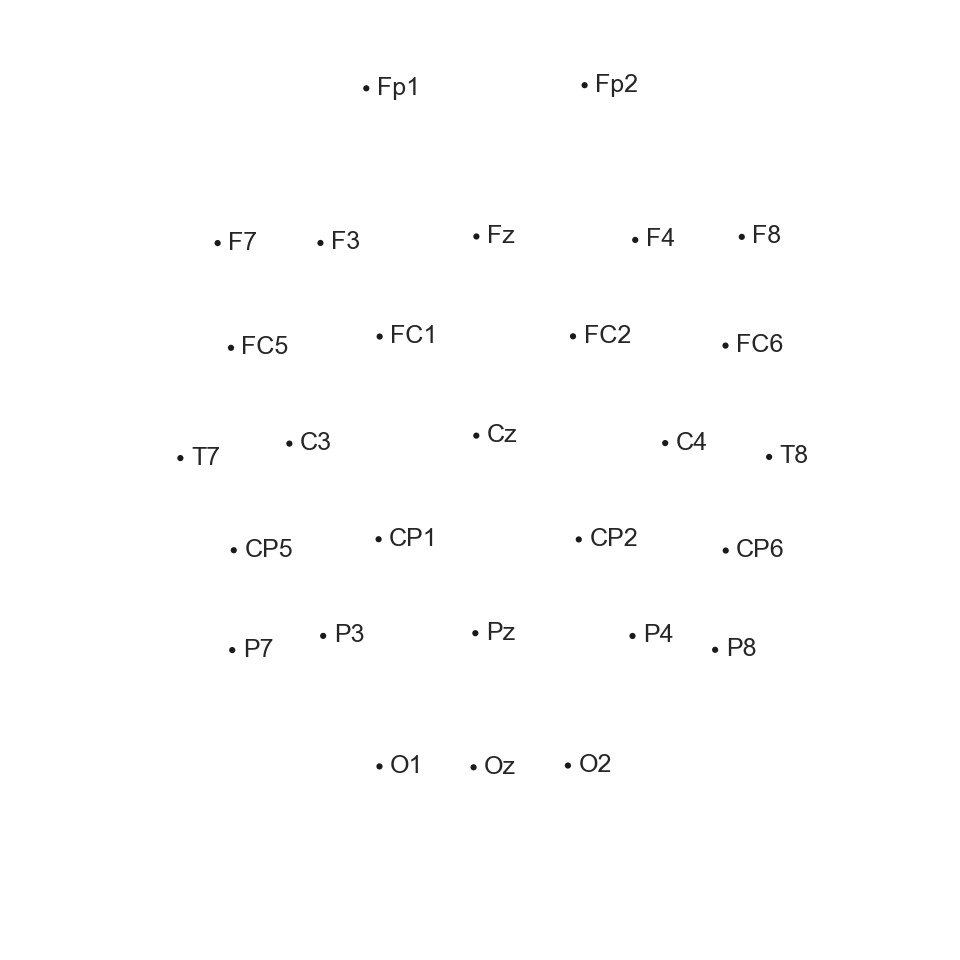

In [20]:
print(data_raw.annotations)
#data_raw.annotations.save(os.path.join('work_data', r'2math-annot.csv'))
data_raw.plot_sensors(ch_type='eeg', show_names=True)
print()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


<IPython.core.display.Javascript object>


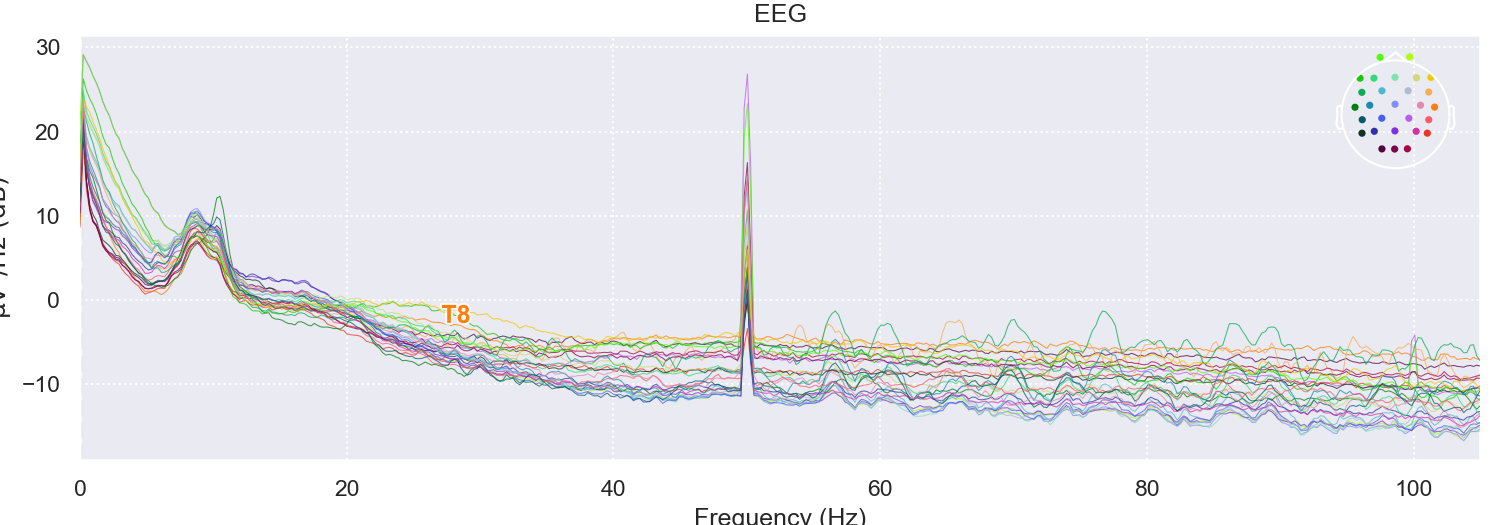

In [21]:
data_raw.plot_psd(fmin=0, fmax=105)
print()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1835 samples (3.670 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    2.5s finished


<IPython.core.display.Javascript object>


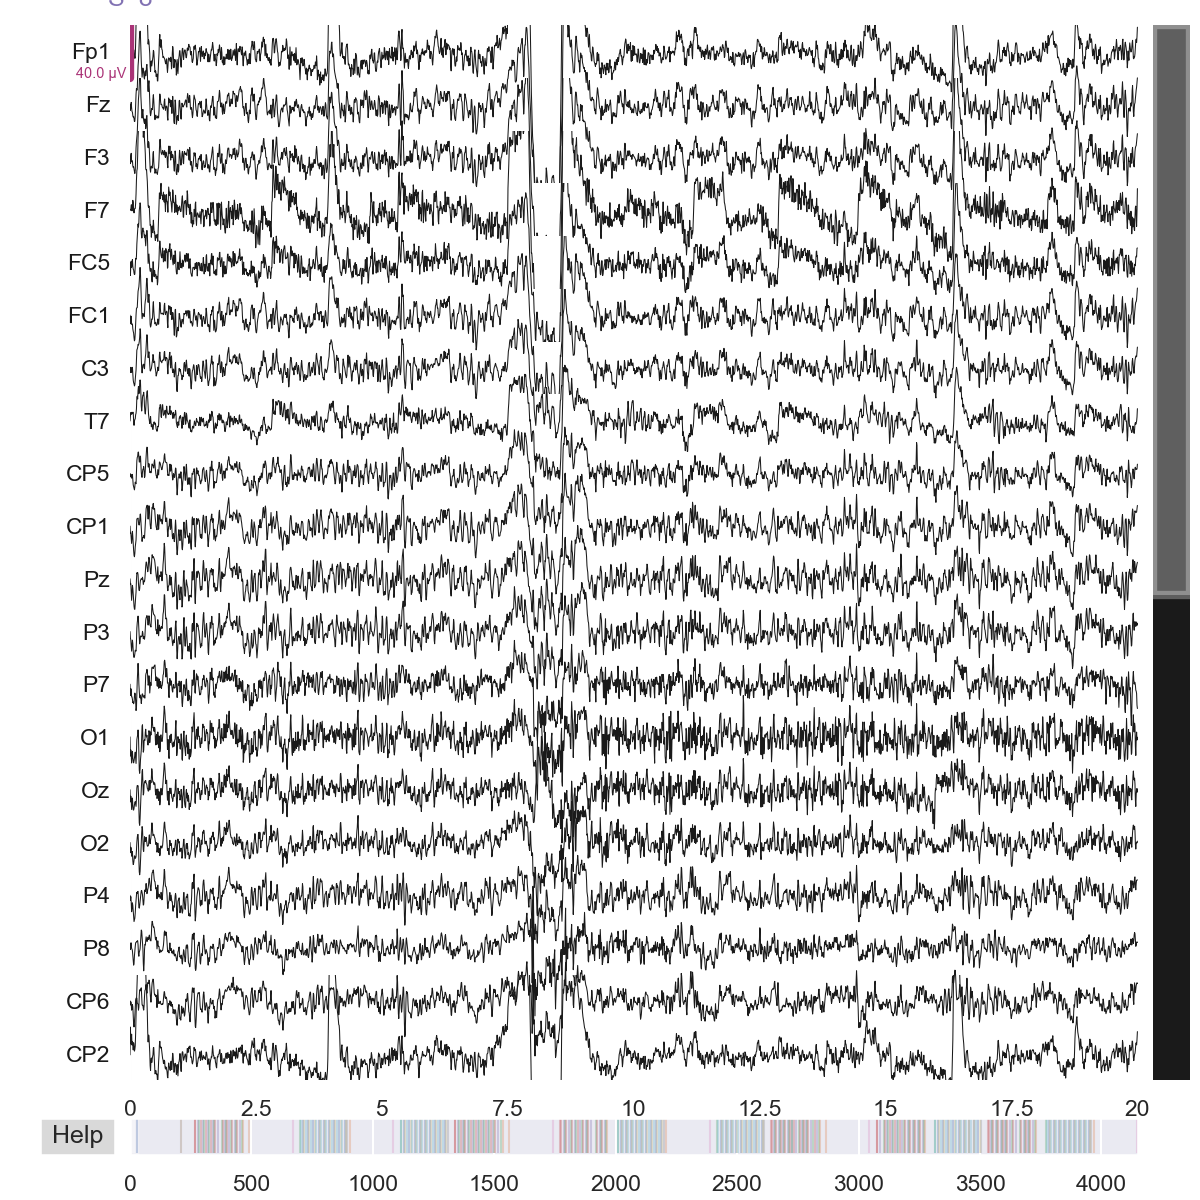

Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1835 samples (3.670 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    2.6s finished


<IPython.core.display.Javascript object>


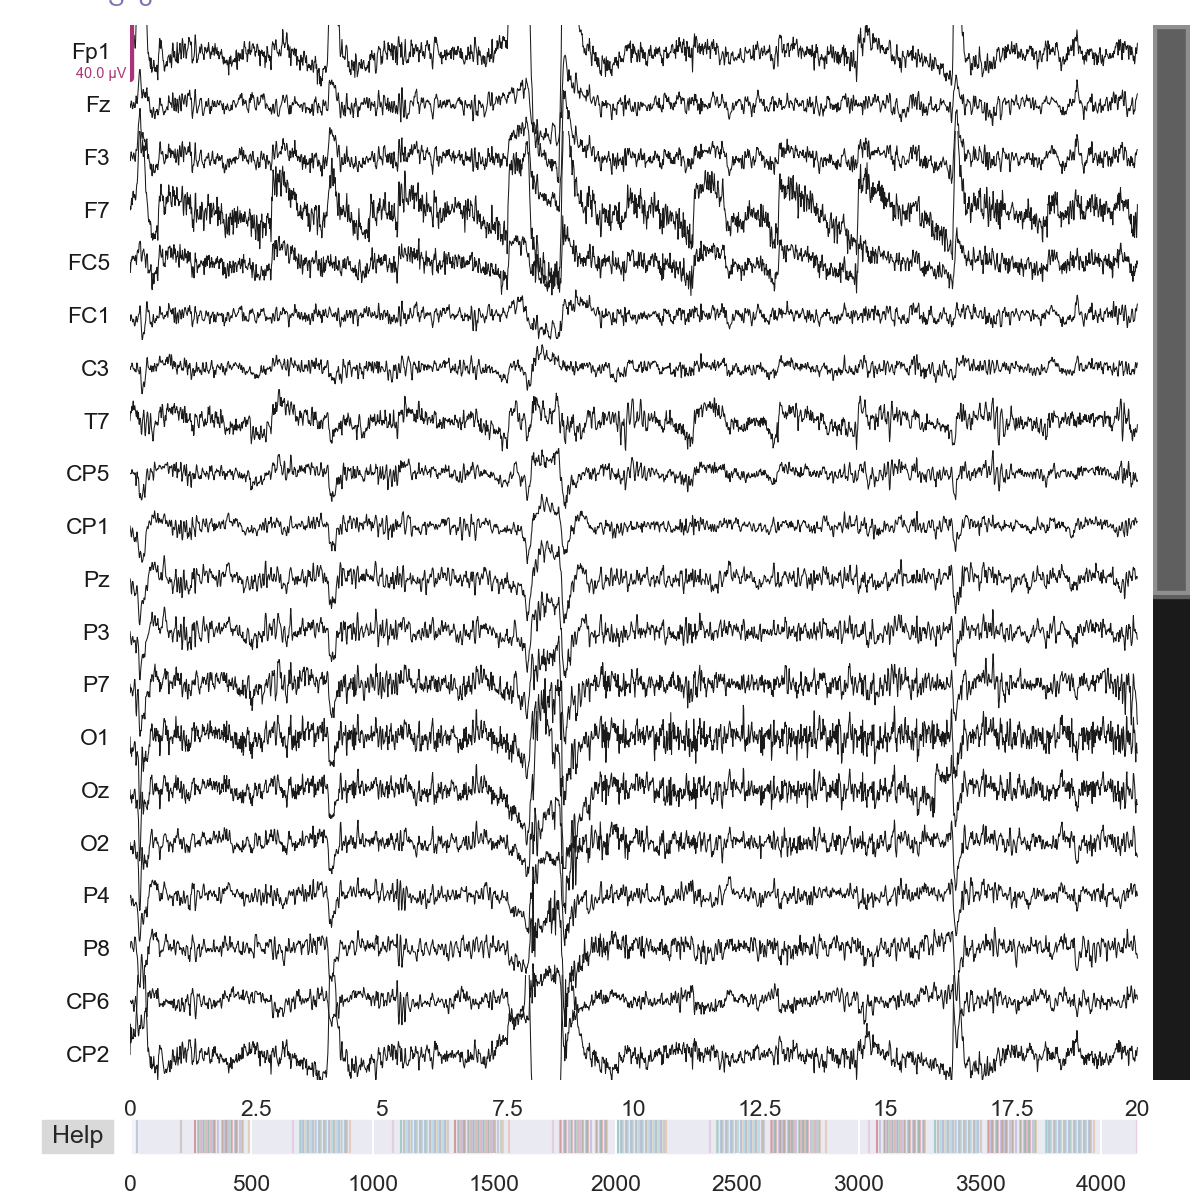

In [22]:
# Re-referencing raw data (common average reference)
bands = [(0.9, 4, 'Delta (0.9-4 Hz)'), (4, 8, 'Theta (4-8 Hz)'), (8, 14, 'Alpha (8-14 Hz)'), 
         (14, 25, 'Beta (14-25 Hz)'), (25, 40, 'Gamma (25-40 Hz)')]

data_raw_filt = data_raw.copy().filter(l_freq=bands[0][0], h_freq=bands[-1][1])
fig_orig = data_raw_filt.plot(duration=20)

rr_data_raw, ref_ch = mne.set_eeg_reference(data_raw, ref_channels='average', copy=True, projection=False, ch_type='eeg')
rr_data_raw_filt = rr_data_raw.copy().filter(l_freq=bands[0][0], h_freq=bands[-1][1])
fig_reref = rr_data_raw_filt.plot(duration=20)

print()

# Preprocessing data

## ICA analysis 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


Fitting ICA to data using 28 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    2.3s finished


Selecting by explained variance: 17 components
Fitting ICA took 92.9s.
Creating RawArray with float64 data, n_channels=19, n_times=2074191
    Range : 522499 ... 2596689 =   1044.998 ...  5193.378 secs
Ready.


<IPython.core.display.Javascript object>


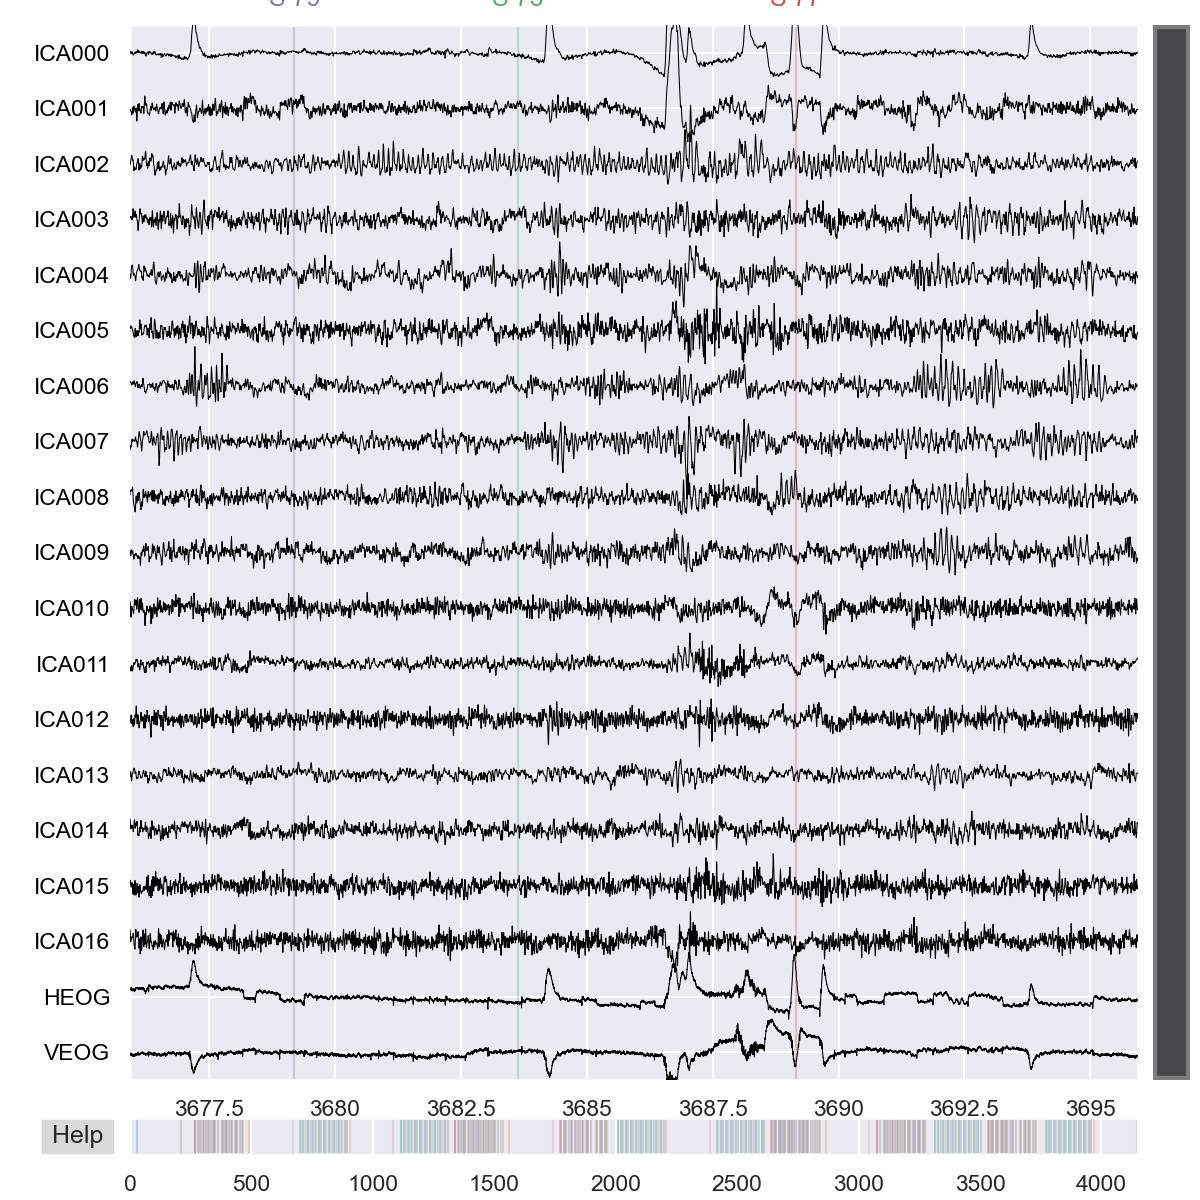

<IPython.core.display.Javascript object>


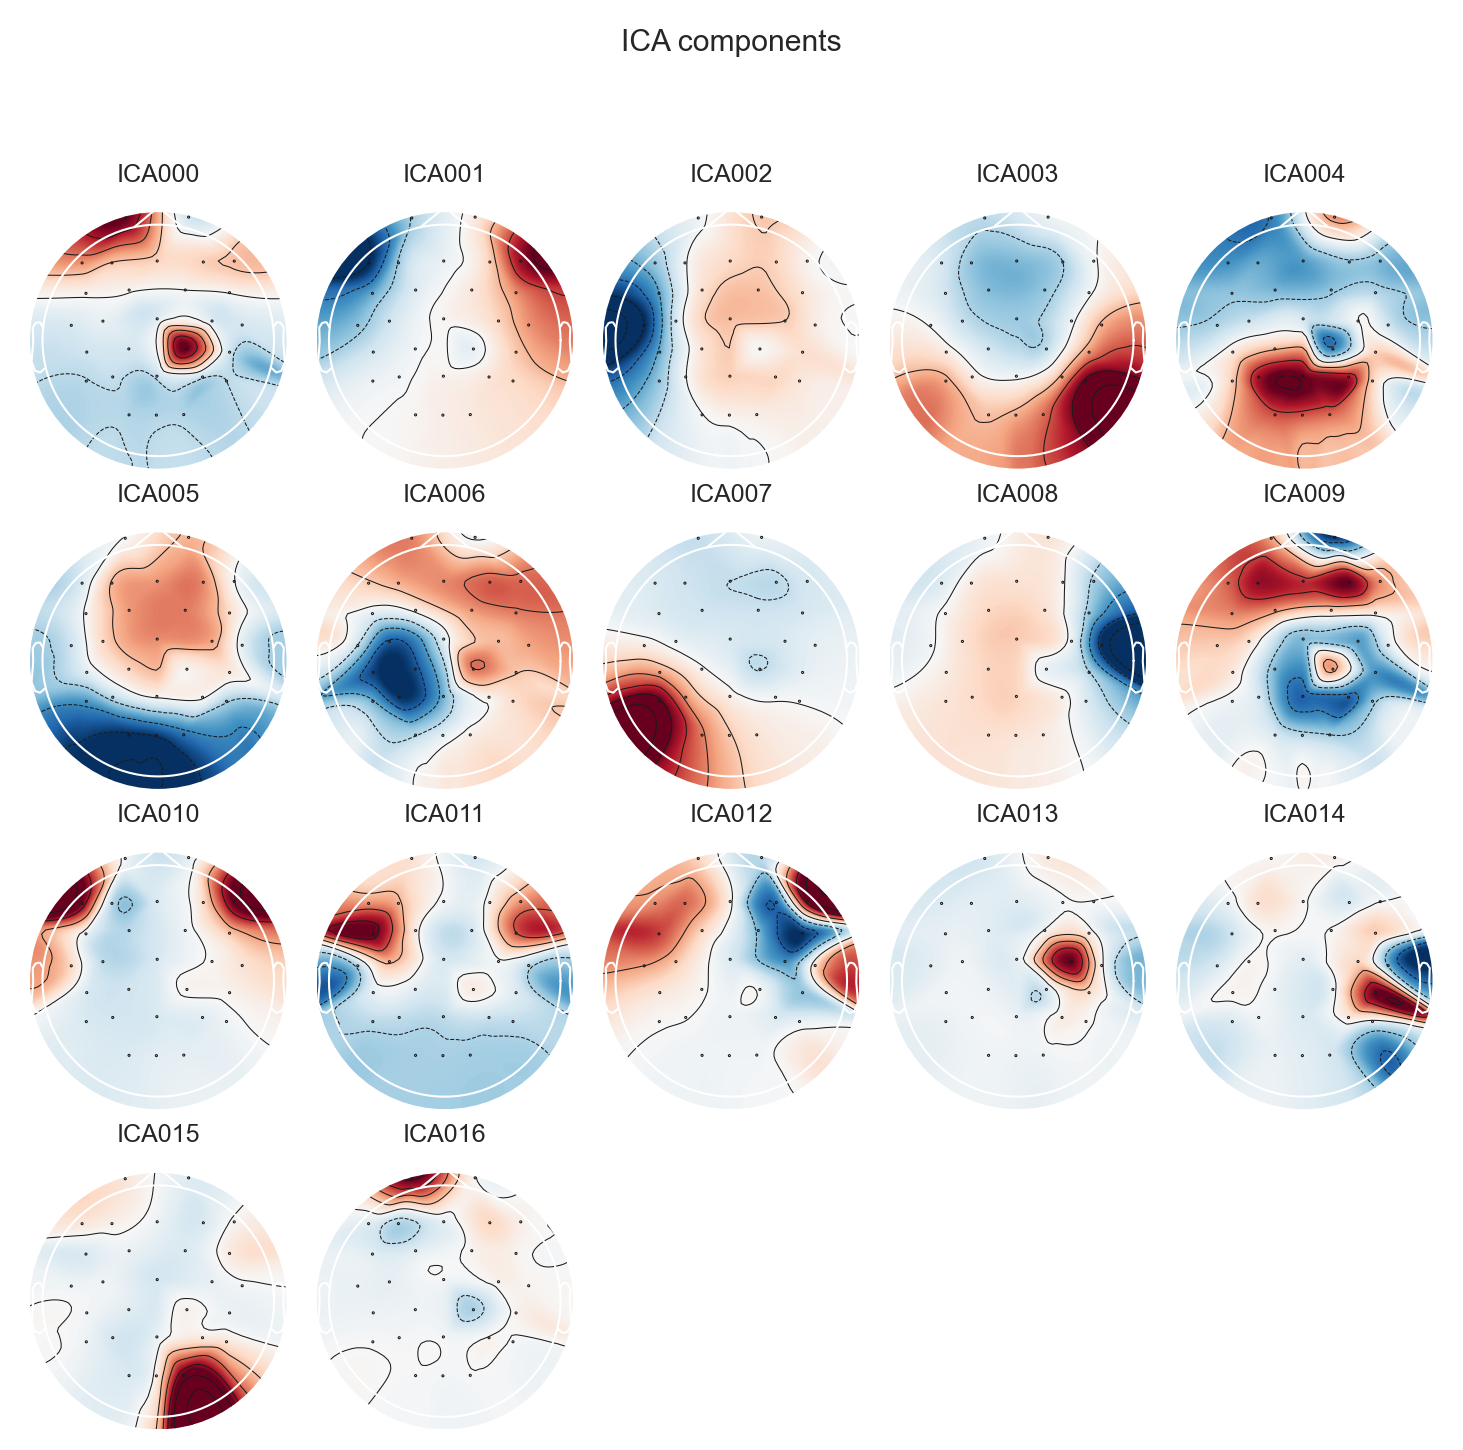

[<MNEFigure size 975x967 with 17 Axes>]

In [23]:
rr_data_ica = rr_data_raw.copy()
#rr_data_ica.info['bads']=["O1","F7"]
#rr_data_ica.interpolate_bads(reset_bads=True)

rr_data_ica.filter(l_freq=1., h_freq=40)

rr_ica = ICA(n_components=.99, max_iter='auto', random_state=97)
rr_ica.fit(rr_data_ica)

rr_ica.plot_sources(rr_data_ica)
rr_ica.plot_components()

Using EOG channel: VEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)

<IPython.core.display.Javascript object>


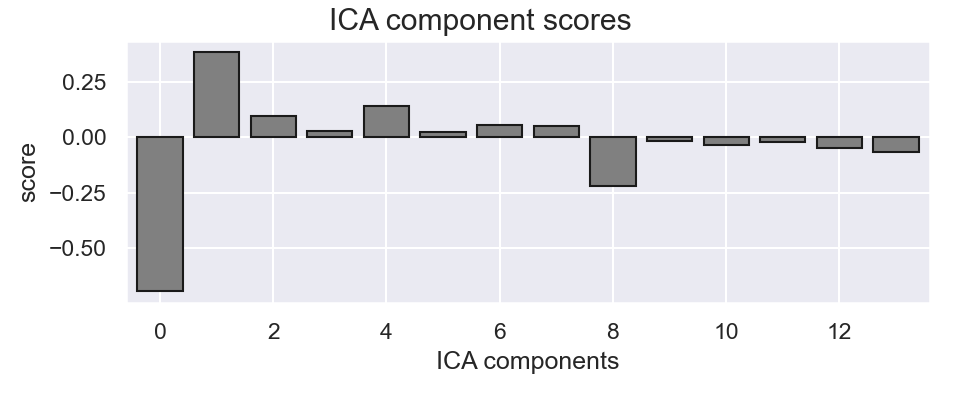

In [23]:
rr_ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = rr_ica.find_bads_eog(rr_data_ica, ch_name= 'Fp2')
rr_ica.exclude = eog_indices

print(rr_ica.exclude)
print(eog_scores)

rr_ica.plot_scores(eog_scores)
print()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1835 samples (3.670 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    2.4s finished


Not setting metadata
2073 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2073 events and 501 original time points ...
0 bad epochs dropped
No projector specified for this dataset. Please consider the method self.add_proj.


<IPython.core.display.Javascript object>


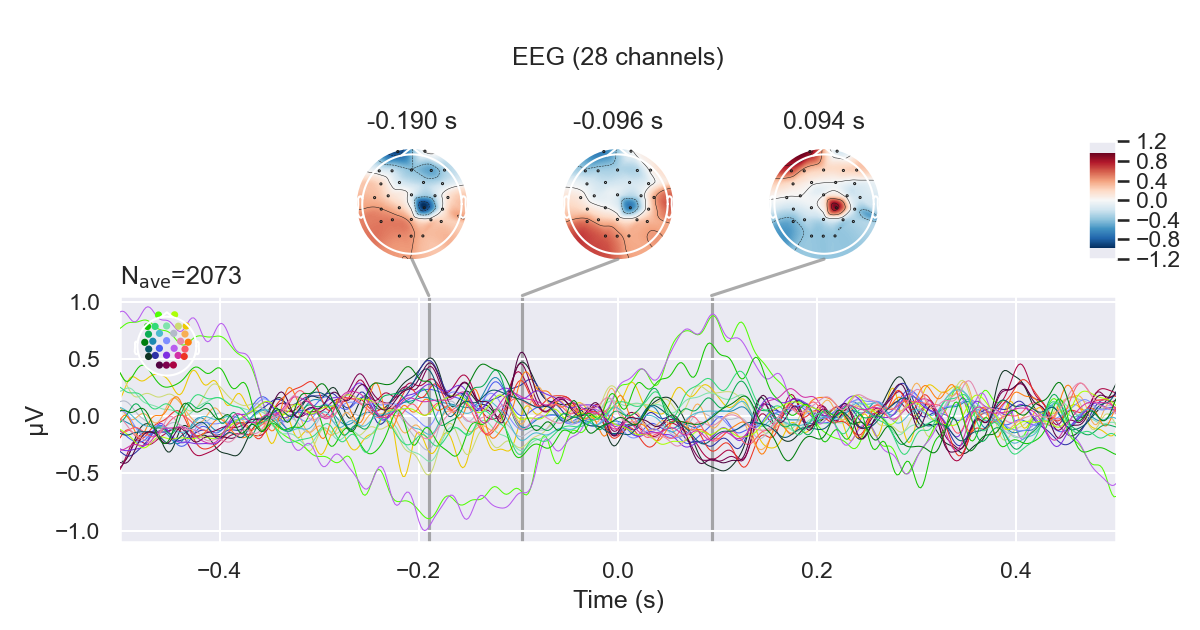

Applying ICA to Evoked instance
    Transforming to ICA space (17 components)
    Zeroing out 2 ICA components
    Projecting back using 28 PCA components


<IPython.core.display.Javascript object>


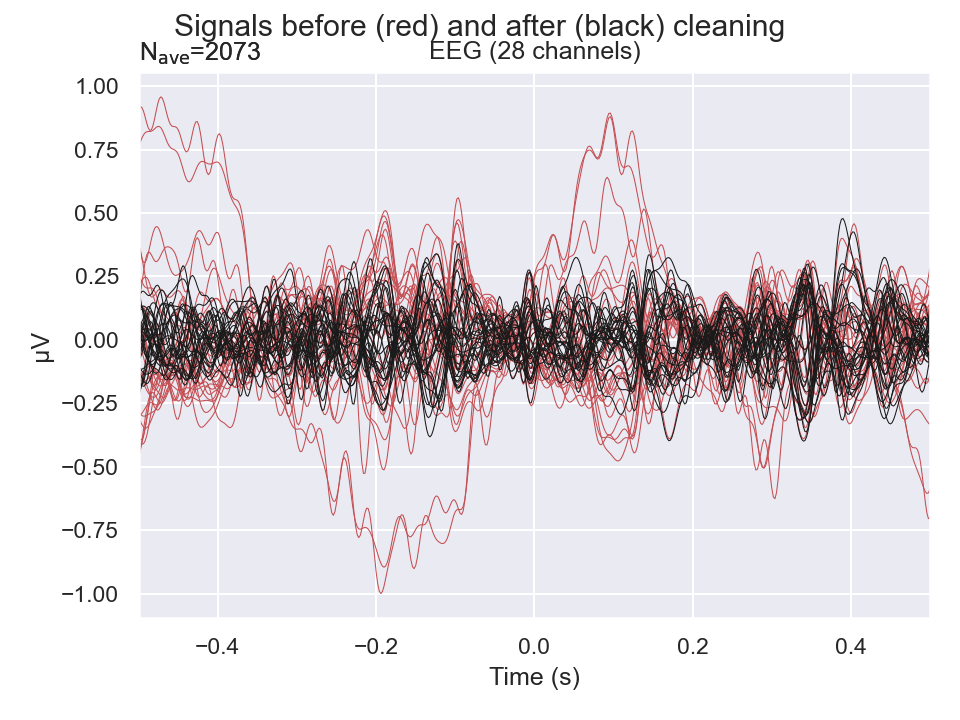

In [25]:
# Explore the effect of excluding particular ICA components

rr_data_filt = rr_data_raw.copy().filter(l_freq=bands[0][0], h_freq=bands[-1][1])

fix_events_raw = mne.make_fixed_length_events(rr_data_filt, start=0.5, duration=2.)#, overlap=0.2)
kwargs = dict(baseline=None, tmin=-0.5, tmax=0.5, preload=True)

evoked_fix = mne.Epochs(rr_data_filt, fix_events_raw.astype(int), **kwargs).average()

evoked_fix.pick('eeg').plot_joint()

rr_ica.plot_overlay(evoked_fix.pick('eeg'), exclude=[0,1]) # ICA components to exclude
#rr_ica.plot_properties(rr_data_raw, picks=[2])
print()

In [26]:
# Excluding EOG and bad channels (re-referenced data)

rr_ica.exclude = [0,1] # ICA components to exclude
reref_data = rr_data_raw.copy()
rr_ica.apply(reref_data)


Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 2 ICA components
    Projecting back using 28 PCA components


<RawEDF | 23_math-edf.edf, 38 x 2074191 (4148.4 s), ~601.4 MB, data loaded>

# Events and cropping data

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1835 samples (3.670 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    2.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.05 Hz (-6 dB cutoff frequency: 0.03 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 33001 samples (66.002 sec)



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished


<IPython.core.display.Javascript object>


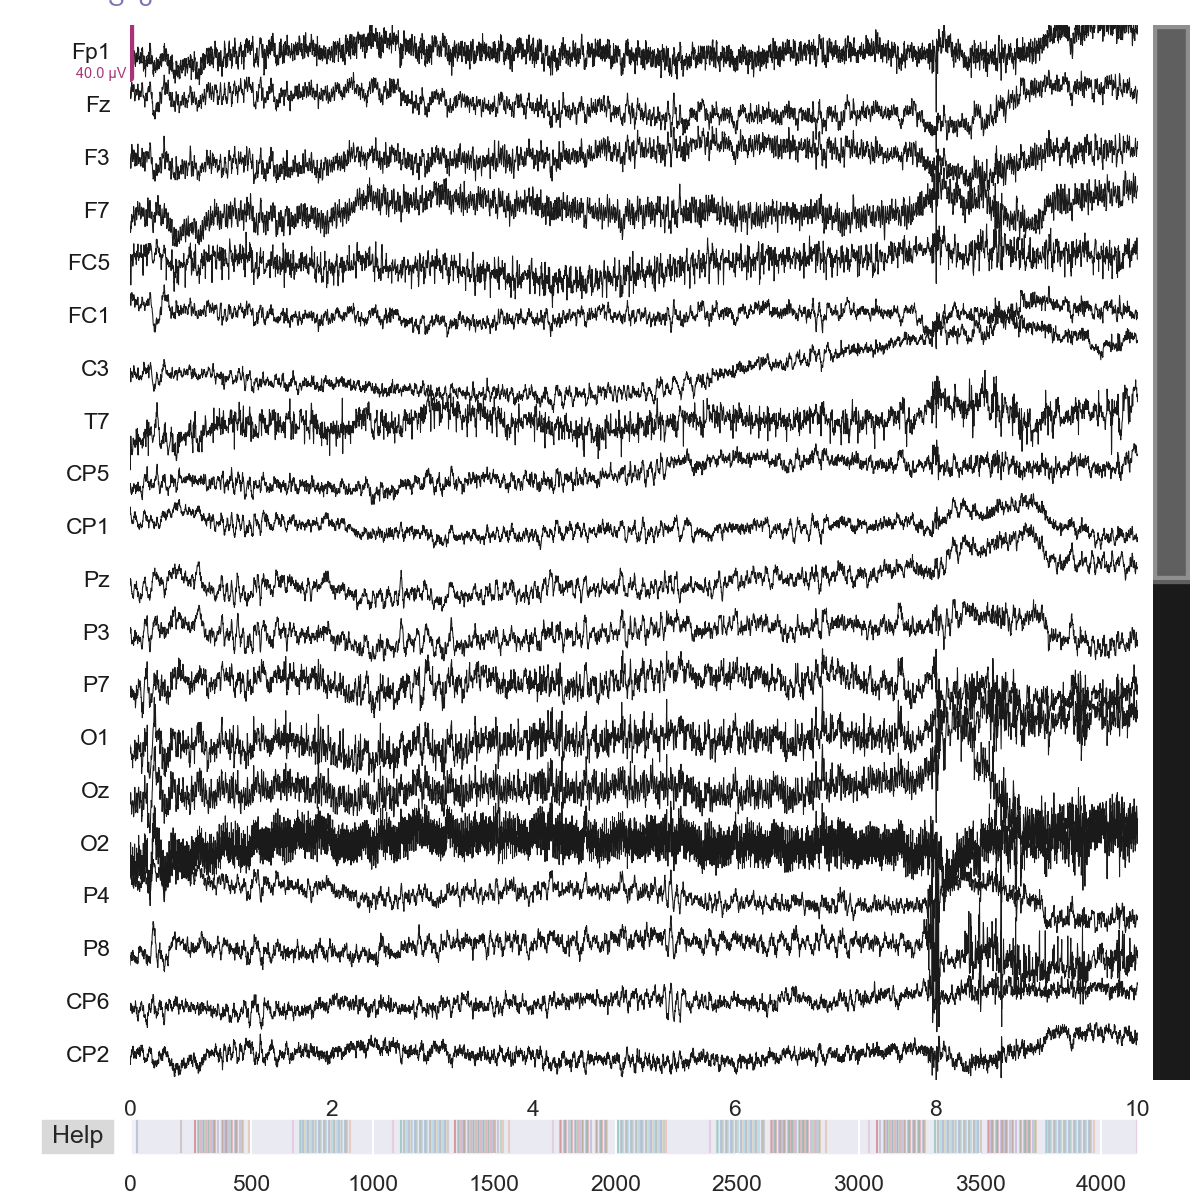

<IPython.core.display.Javascript object>


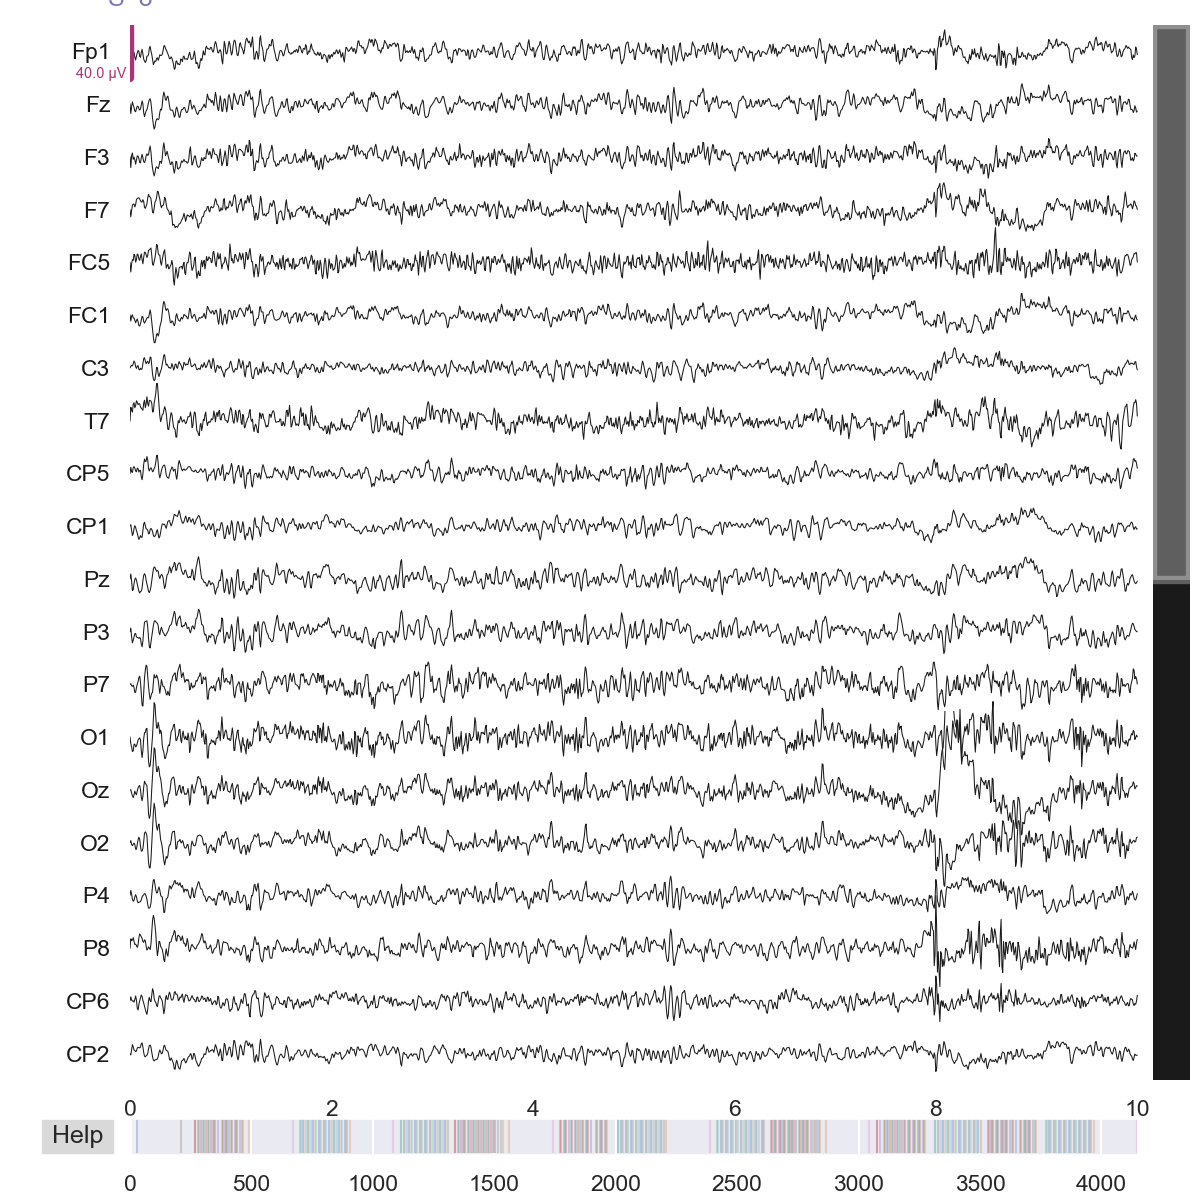

In [27]:
# Filtering raw_data

bands = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 8, 'Theta (4-8 Hz)', 'T'), (8, 14, 'Alpha (8-14 Hz)', 'A'), 
         (14, 25, 'Beta (14-25 Hz)', 'B'), (25, 40, 'Gamma (25-40 Hz)', 'G')]

bands_test = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 7, 'Theta (4-7 Hz)', 'T'), (7, 10, 'Alpha1 (7-10 Hz)','A1'), 
         (10, 13, 'Alpha2 (10-13 Hz)', 'A2'), (13, 20, 'Beta1 (13-20 Hz)', 'B1'), (20, 30, 'Beta2 (20-30 Hz)', 'B2'), 
         (30, 45, 'Gamma (30-45 Hz)', 'G')]

str_freq = [bands[i][3] for i in range(len(bands))]
n_freq = len(str_freq)

data_rr_filt = reref_data.copy().filter(l_freq=bands[0][0], h_freq=bands[-1][1], picks='eeg')
#data_rr_filt = data_rr_filt.filter(l_freq=1, h_freq=40, picks='eog')
#data_rr_filt = data_rr_filt.filter(l_freq=0.5, h_freq=40, picks='heartrate')
#data_rr_filt = data_rr_filt.filter(l_freq=0.05, h_freq=10, picks=['respiratory','skinconductance'])

reref_data.plot()
data_rr_filt.plot()
print()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


<IPython.core.display.Javascript object>


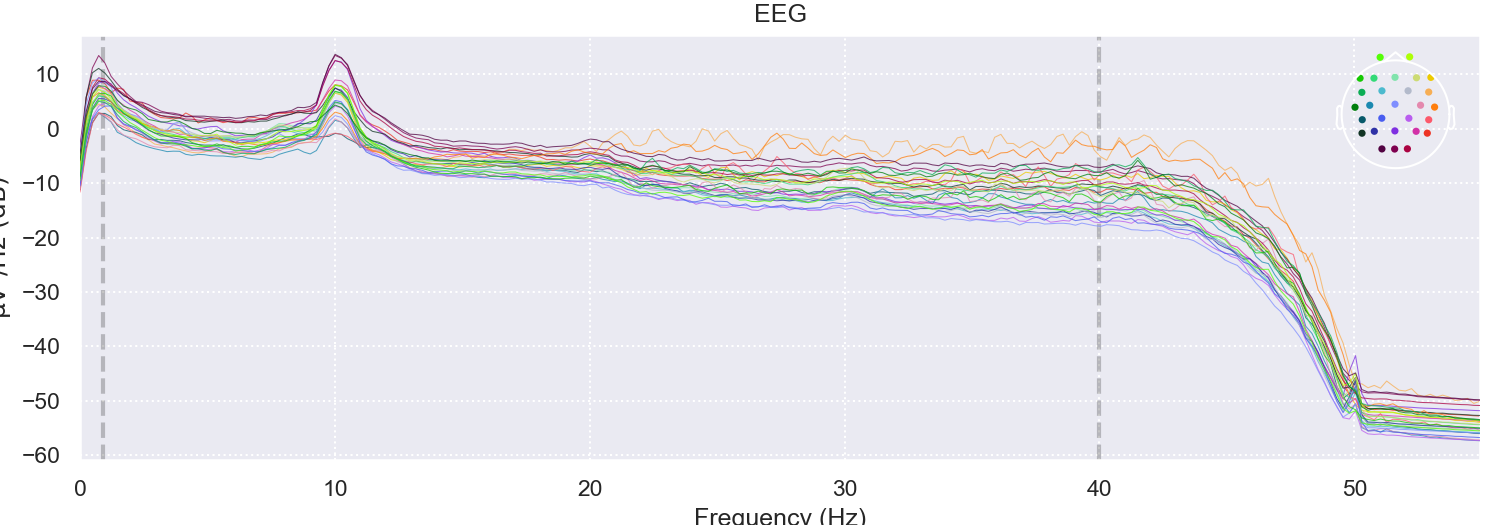

In [40]:
data_rr_filt.plot_psd(fmin=0, fmax=55)
print()

# Explore annotations

363
38 <Annotations | 38 segments: S 4 (1), S 5 (6), S 6 (6), S 7 (6), S 44 (1), ...>


<IPython.core.display.Javascript object>


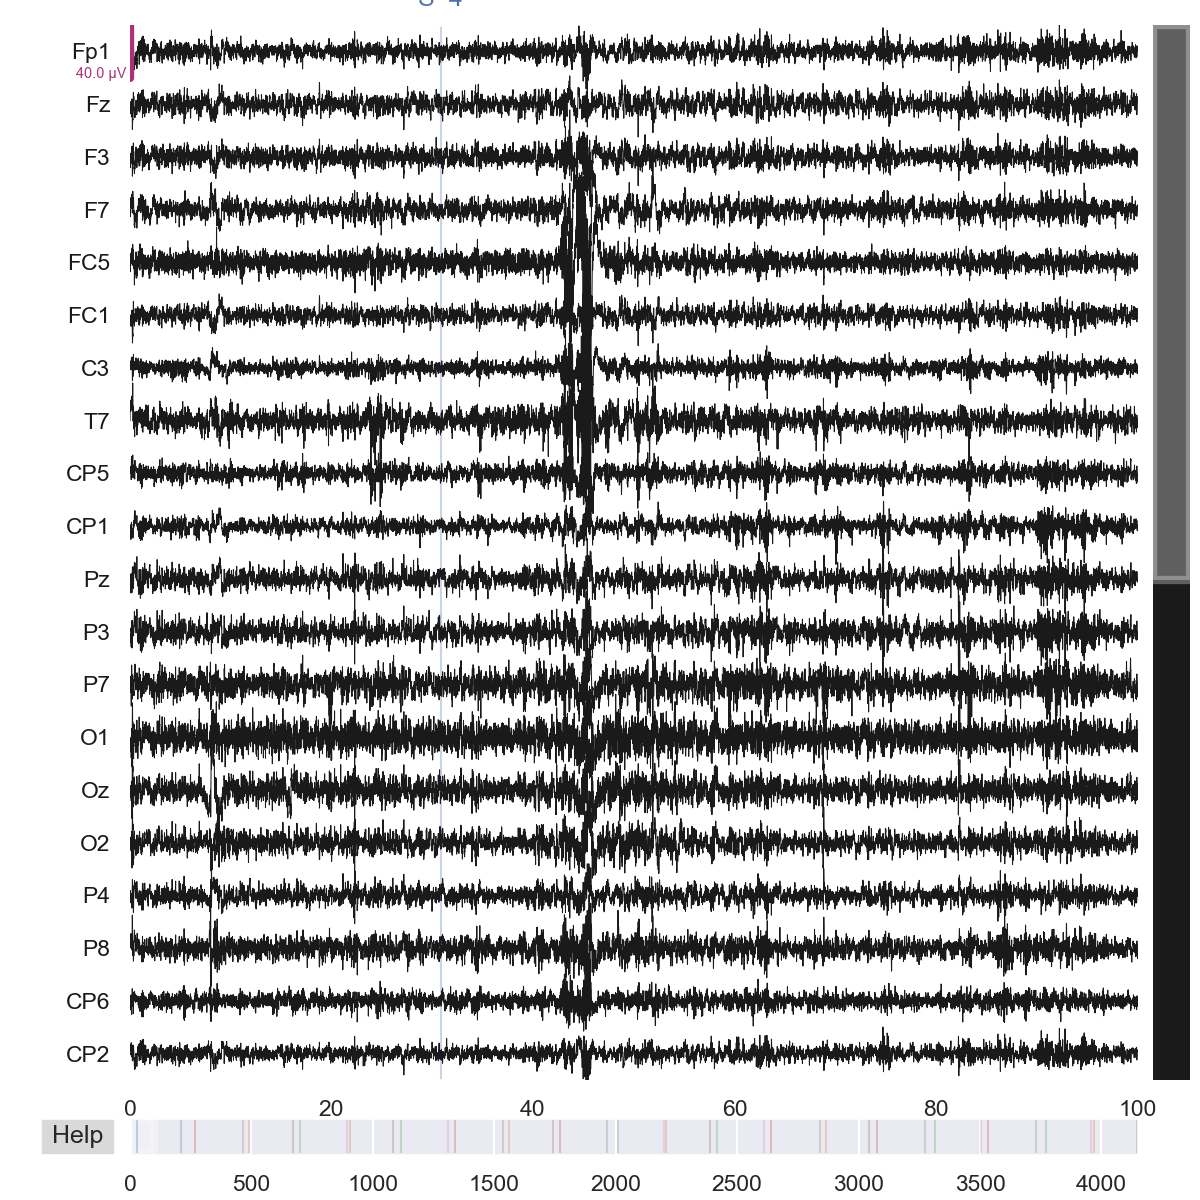

In [29]:
# Delete unnecessary annotations

ann = data_rr_filt.annotations.copy()
print(len(ann))

del_ann_ind = []
for i in range(len(ann)):
    if (ann[i]['description'] in [ 'New Segment', 'S  8', 'S 66', 'S 69', 'S 63', 'S 77', 'S 79', 'S 73']):
        del_ann_ind += [i]
#print(del_ann_ind)
data_rr_filt.annotations.delete(del_ann_ind)
print(len(data_rr_filt.annotations), data_rr_filt.annotations)

data_rr_filt.plot(duration=100)
print()

Used Annotations descriptions: ['S  4', 'S  5', 'S  6', 'S  7', 'S 44', 'S 50', 'S 60', 'S 70']
{'S  4': 1, 'S  5': 2, 'S  6': 3, 'S  7': 4, 'S 44': 5, 'S 50': 6, 'S 60': 7, 'S 70': 8}
38


<IPython.core.display.Javascript object>


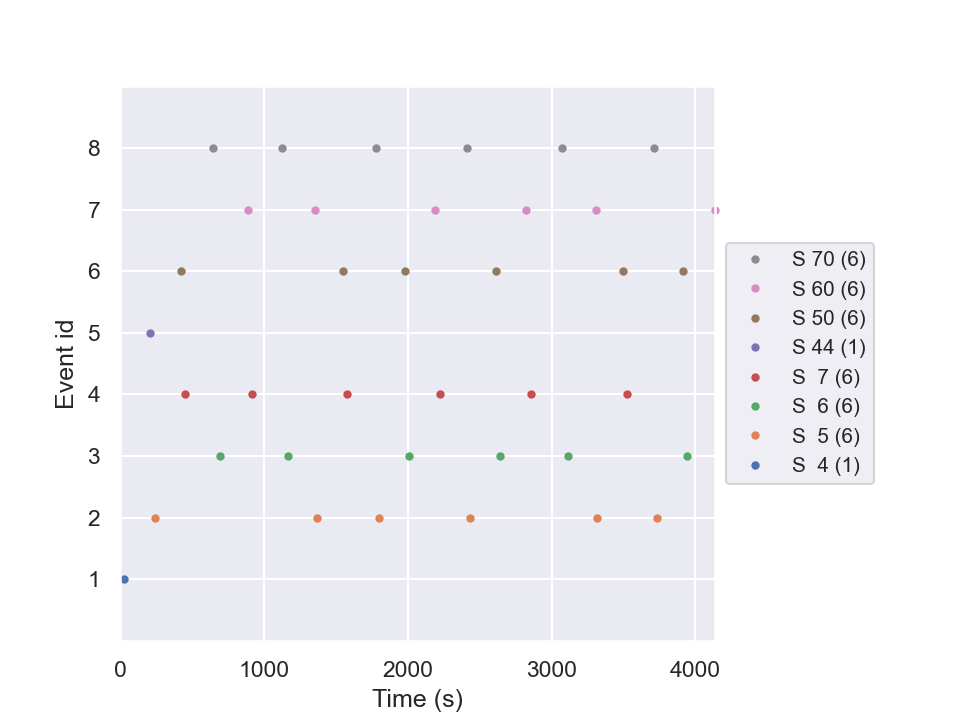

In [42]:
# Convert annotations to events and plot events

events_from_annot, event_dict = mne.events_from_annotations(data_rr_filt)
print(event_dict)
print(len(events_from_annot))

fig = mne.viz.plot_events(events_from_annot, event_id=event_dict, sfreq=data_rr_filt.info['sfreq'], first_samp=data_rr_filt.first_samp)

In [43]:
# Cropping data (event-related)

annot = data_rr_filt.annotations.copy()
annot_onsets = annot.onset - data_rr_filt.first_time
print(annot_onsets.shape, annot_onsets)
print(data_rr_filt.first_time)

# Main baseline
baseline_main_raw = data_rr_filt.copy().crop(tmin=annot_onsets[0], tmax=annot_onsets[1])
print(annot.description[0], annot.description[1], baseline_main_raw.n_times/samp_rate)

# Stages & stage baselines
stages_raw = []
#baselines_raw = []
stage_types = []
for i in range(len(annot)):
    if (annot.description[i] in {'S  5', 'S  6', 'S  7'}):
        stages_raw.append(data_rr_filt.copy().crop(tmin=annot_onsets[i], tmax=annot_onsets[i+1]))
        #baselines_raw.append(data_rr_filt.copy().crop(tmin=annot_onsets[i]-20.5, tmax=annot_onsets[i]))
        stage_types.append(int(annot.description[i][-1]))
        print(annot.description[i], annot.description[i+1], 
              stages_raw[-1].n_times/samp_rate)#, baselines_raw[-1].n_times/samp_rate)
         
print(len(stages_raw))
#print(len(baselines_raw))
print(len(stage_types), stage_types)

# Initialize n_stages
n_stages = len(stage_types)


(38,) [  25.212  205.214  242.514  422.514  453.53   648.314  694.014  890.864
  920.866 1126.4   1170.5   1357.566 1367.566 1547.568 1578.584 1782.052
 1801.434 1981.434 2012.452 2193.286 2223.286 2410.686 2431.586 2611.586
 2642.604 2824.788 2854.77  3071.122 3111.354 3306.722 3316.722 3496.722
 3527.74  3711.29  3730.872 3910.874 3941.89  4137.91 ]
449.022
S  4 S 44 180.004
S  5 S 50 180.002
S  7 S 70 194.786
S  6 S 60 196.852
S  7 S 70 205.536
S  6 S 60 187.068
S  5 S 50 180.004
S  7 S 70 203.47
S  5 S 50 180.002
S  6 S 60 180.836
S  7 S 70 187.402
S  5 S 50 180.002
S  6 S 60 182.186
S  7 S 70 216.354
S  6 S 60 195.37
S  5 S 50 180.002
S  7 S 70 183.552
S  5 S 50 180.004
S  6 S 60 196.022
18
18 [5, 7, 6, 7, 6, 5, 7, 5, 6, 7, 5, 6, 7, 6, 5, 7, 5, 6]


In [44]:
# Saving filtered and cropped raw data

# Initialize n_stages
n_stages = len(stage_types)

raw_dir_path = os.path.join(root_dir_path, 'stages_raw')
if not os.path.exists(raw_dir_path):
    os.mkdir(raw_dir_path)

# Stage types
np.savetxt(os.path.join(raw_dir_path, 'stage_types.txt'), stage_types)

# Raw data
for _st in range(n_stages):
    stages_raw[_st].save(os.path.join(raw_dir_path, 'st_'+str(_st+1)+'_raw.fif'), overwrite=True)
    #baselines_raw[_st].save(os.path.join(raw_dir_path, 'bl_'+str(_st+1)+'_raw.fif'), overwrite=True)
    print(stages_raw[_st].get_data().shape)
baseline_main_raw.save(os.path.join(raw_dir_path, 'bl_main_raw.fif'), overwrite=True)


Overwriting existing file.
Writing C:\Users\Lenovo\PycharmProjects\Huawei\work_data\24_math\stages_raw\st_1_raw.fif
Closing C:\Users\Lenovo\PycharmProjects\Huawei\work_data\24_math\stages_raw\st_1_raw.fif
[done]
(38, 90001)
Overwriting existing file.
Writing C:\Users\Lenovo\PycharmProjects\Huawei\work_data\24_math\stages_raw\st_2_raw.fif
Closing C:\Users\Lenovo\PycharmProjects\Huawei\work_data\24_math\stages_raw\st_2_raw.fif
[done]
(38, 97393)
Overwriting existing file.
Writing C:\Users\Lenovo\PycharmProjects\Huawei\work_data\24_math\stages_raw\st_3_raw.fif
Closing C:\Users\Lenovo\PycharmProjects\Huawei\work_data\24_math\stages_raw\st_3_raw.fif
[done]
(38, 98426)
Overwriting existing file.
Writing C:\Users\Lenovo\PycharmProjects\Huawei\work_data\24_math\stages_raw\st_4_raw.fif
Closing C:\Users\Lenovo\PycharmProjects\Huawei\work_data\24_math\stages_raw\st_4_raw.fif
[done]
(38, 102768)
Overwriting existing file.
Writing C:\Users\Lenovo\PycharmProjects\Huawei\work_data\24_math\stages_raw\